# **P7 - Implentez un modèle de scoring**

## Sommaire

1. [Import](#Import)  
2. [Initiation d'un environnement MLFlow](#Initiation-d'un-environnement-MLFlow)    
3. [Préparation des données](#Préparation-des-données)
4. [Cout métier](#Cout-métier)
5. [Grid](#Grid)
6. [Feature Importance](#Feature-Importance)
    1. [Importance globale](#Importance-globale)  
    2. [Importance locale](#Importance-locale)
7. [Données necessaire à API](#Données-necessaire-à-API)

## Import

In [125]:
import mlflow
import mlflow.sklearn
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import gc
import time
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm
from lightgbm import LGBMClassifier
from lightgbm import early_stopping
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from imblearn.over_sampling import SMOTE
import shap
import lightgbm as lgb
import joblib

In [127]:
import importlib.metadata

# Liste des bibliothèques utilisées
libraries = [
    "mlflow", "numpy", "scikit-learn", "pandas", "seaborn", "matplotlib", "lightgbm",
    "imbalanced-learn", "shap", "joblib"
]

# Affichage des versions
versions = {lib: importlib.metadata.version(lib) for lib in libraries}
for lib, version in versions.items():
    print(f"{lib}: {version}")

mlflow: 2.20.2
numpy: 1.26.4
scikit-learn: 1.4.2
pandas: 2.2.2
seaborn: 0.13.2
matplotlib: 3.8.4
lightgbm: 4.6.0
imbalanced-learn: 0.12.3
shap: 0.46.0
joblib: 1.4.2


## Initiation d'un environnement MLFlow

Dans un premier temps commençons par définir l'URL de notre environnement MLFlow. Nous utiliserons "mlflow ui" dans anaconda prompt.

In [132]:
# Définir l'URI du serveur de tracking
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# Définis l'expérience
mlflow.set_experiment("MLflow_scoring")

<Experiment: artifact_location='mlflow-artifacts:/492730608176477163', creation_time=1739977718379, experiment_id='492730608176477163', last_update_time=1739977718379, lifecycle_stage='active', name='MLflow_scoring', tags={}>

Cela étant fait essayons de générer des données fictives afin de voir si tous fonctionne :

In [135]:
# Génération de données factices
X, y = make_regression(n_samples=100, n_features=2, noise=0.1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Début d'une expérimentation MLflow
with mlflow.start_run():
    # Initialisation et entraînement du modèle
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Prédictions et évaluation
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    # Logging des métriques
    mlflow.log_metric("MSE", mse)

    # Exemple d'entrée pour éviter l'avertissement
    example_input = np.array([X_test[0]])  

    # Logging du modèle avec un exemple d'entrée
    mlflow.sklearn.log_model(model, "linear_regression_model", input_example=example_input)

print("Expérimentation MLflow enregistrée avec succès !")

🏃 View run lyrical-snail-933 at: http://127.0.0.1:5000/#/experiments/492730608176477163/runs/0e05a28f7c4a432883a9c6006de64556
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/492730608176477163
Expérimentation MLflow enregistrée avec succès !


Aucun problème à signaler. Les liens sont bien mis à disposition et fonctionnent. On peut désormais commencer notre projet.

## Préparation des données

A l'aide du kernel mis à disposition, on peut commencer à obtenir notre base de données nettoyer et exploitable :

In [139]:
class DataLoader:
    def __init__(self, file_paths):
        self.file_paths = file_paths

    def load_data(self):
        df = pd.read_csv(self.file_paths['train'])
        test_df = pd.read_csv(self.file_paths['test'])
        return df, test_df

class DataPreprocessor:
    def __init__(self):
        pass

    def one_hot_encoder(self, df, nan_as_category=True):
        original_columns = list(df.columns)
        categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
        df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
        new_columns = [c for c in df.columns if c not in original_columns]
        return df, new_columns

    def preprocess_data(self, df, test_df):
        df = pd.concat([df, test_df], ignore_index=True)
        df = df[df['CODE_GENDER'] != 'XNA']
        df, _ = self.one_hot_encoder(df)

        df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].replace(365243, np.nan)
        df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
        df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
        df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
        df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
        df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']

        return df


def main():
    file_paths = {'train': 'application_train.csv', 'test': 'application_test.csv'}
    loader = DataLoader(file_paths)
    df, test_df = loader.load_data()

    preprocessor = DataPreprocessor()
    df = preprocessor.preprocess_data(df, test_df)

    # DataFrame prêt pour l'analyse exploratoire
    df.to_csv('preprocessed_data.csv', index=False)
    print("DataFrame préparé et sauvegardé sous 'preprocessed_data.csv'")

    # L'entraînement du modèle se fera plus tard, une fois les analyses exploratoires terminées

if __name__ == '__main__':
    main()

DataFrame préparé et sauvegardé sous 'preprocessed_data.csv'


In [140]:
df = pd.read_csv("preprocessed_data.csv")
df.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_nan,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_nan,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_CAR_nan,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,FLAG_OWN_REALTY_nan,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_nan,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_INCOME_TYPE_nan,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_EDUCATION_TYPE_nan,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_FAMILY_STATUS_nan,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,NAME_HOUSING_TYPE_nan,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,OCCUPATION_TYPE_nan,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_

In [141]:
# Afficher toutes les colonnes
pd.set_option('display.max_columns', None)

# Afficher les types de données de toutes les colonnes
df.info ()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356251 entries, 0 to 356250
Columns: 266 entries, SK_ID_CURR to PAYMENT_RATE
dtypes: bool(155), float64(72), int64(39)
memory usage: 354.4 MB


In [142]:
# Rechercher les colonnes de type 'object' ou 'category'
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
print(f"Colonnes catégorielles restantes : {list(categorical_columns)}")

Colonnes catégorielles restantes : []


Cherchons à determiner si certaines variables disposent de valeurs manquantes

In [144]:
# Calculer le pourcentage de valeurs manquantes pour chaque colonne
missing_percentage = df.isnull().mean() * 100

# Créer un DataFrame avec les résultats et trier par pourcentage décroissant
missing_data = missing_percentage[missing_percentage > 10].sort_values(ascending=False)

# Afficher les colonnes avec des valeurs manquantes et leur pourcentage
missing_data

COMMONAREA_MODE                 69.714050
COMMONAREA_AVG                  69.714050
COMMONAREA_MEDI                 69.714050
NONLIVINGAPARTMENTS_MODE        69.293560
NONLIVINGAPARTMENTS_AVG         69.293560
NONLIVINGAPARTMENTS_MEDI        69.293560
LIVINGAPARTMENTS_MEDI           68.203879
LIVINGAPARTMENTS_AVG            68.203879
LIVINGAPARTMENTS_MODE           68.203879
FLOORSMIN_MODE                  67.678687
FLOORSMIN_MEDI                  67.678687
FLOORSMIN_AVG                   67.678687
YEARS_BUILD_MODE                66.330761
YEARS_BUILD_AVG                 66.330761
YEARS_BUILD_MEDI                66.330761
OWN_CAR_AGE                     66.031815
LANDAREA_MEDI                   59.183553
LANDAREA_AVG                    59.183553
LANDAREA_MODE                   59.183553
BASEMENTAREA_MEDI               58.268749
BASEMENTAREA_AVG                58.268749
BASEMENTAREA_MODE               58.268749
NONLIVINGAREA_AVG               54.951144
NONLIVINGAREA_MEDI              54

Au vu des résultats obtenus on peut remarquer que les variables présentant plus de 20% de valeurs manquantes ne sont pas indispensables à la suite de notre projet. Par conséquents plutôt qu'essayer de les traiter, nous allons les supprimer.

In [146]:
# Supprimer les colonnes avec plus de 20 % de valeurs manquantes
df= df.loc[:, missing_percentage <= 20]

In [147]:
# Calculer le pourcentage de valeurs manquantes pour chaque colonne
missing_percentage = df.isnull().mean() * 100

# Créer un DataFrame avec les résultats et trier par pourcentage décroissant
missing_data = missing_percentage[missing_percentage > 0].sort_values(ascending=False)

# Afficher les colonnes avec des valeurs manquantes et leur pourcentage
missing_data

EXT_SOURCE_3                  19.546050
DAYS_EMPLOYED_PERC            18.146756
DAYS_EMPLOYED                 18.146756
TARGET                        13.682488
AMT_REQ_CREDIT_BUREAU_MON     13.352384
AMT_REQ_CREDIT_BUREAU_WEEK    13.352384
AMT_REQ_CREDIT_BUREAU_DAY     13.352384
AMT_REQ_CREDIT_BUREAU_HOUR    13.352384
AMT_REQ_CREDIT_BUREAU_QRT     13.352384
AMT_REQ_CREDIT_BUREAU_YEAR    13.352384
OBS_60_CNT_SOCIAL_CIRCLE       0.294736
DEF_60_CNT_SOCIAL_CIRCLE       0.294736
OBS_30_CNT_SOCIAL_CIRCLE       0.294736
DEF_30_CNT_SOCIAL_CIRCLE       0.294736
EXT_SOURCE_2                   0.187508
AMT_GOODS_PRICE                0.078035
ANNUITY_INCOME_PERC            0.010105
PAYMENT_RATE                   0.010105
AMT_ANNUITY                    0.010105
INCOME_PER_PERSON              0.000561
CNT_FAM_MEMBERS                0.000561
DAYS_LAST_PHONE_CHANGE         0.000281
dtype: float64

Il faut maintenant s'occuper des variables restantes. Pour ce faire nous allons utiliser "mode" qui va récupérer la valeur la plus fréquentes de la variable.

In [149]:
df = df.fillna(df.mode().iloc[0])

In [150]:
# Calculer le pourcentage de valeurs manquantes pour chaque colonne
missing_percentage = df.isnull().mean() * 100

# Créer un DataFrame avec les résultats et trier par pourcentage décroissant
missing_data = missing_percentage[missing_percentage > 0].sort_values(ascending=False)

# Afficher les colonnes avec des valeurs manquantes et leur pourcentage
missing_data

Series([], dtype: float64)

In [151]:
print(df.columns.tolist())

['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14'

In [152]:
# Liste des colonnes sélectionnées pour le scoring
colonnes_scoring = [
    'SK_ID_CURR', 'TARGET',  # Identifiant & Cible
    'CNT_CHILDREN', 'CNT_FAM_MEMBERS',  # Infos familiales
    'CODE_GENDER_F', 'CODE_GENDER_M',
    'FLAG_OWN_CAR_Y', 'FLAG_OWN_CAR_N',
    'FLAG_OWN_REALTY_Y', 'FLAG_OWN_REALTY_N',
    'NAME_FAMILY_STATUS_Married', 'NAME_FAMILY_STATUS_Single / not married', 'NAME_FAMILY_STATUS_Widow',
    'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',  # Infos financières
    'INCOME_CREDIT_PERC', 'ANNUITY_INCOME_PERC', 'PAYMENT_RATE',  # Ratios financiers
    'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_EMPLOYED_PERC',  # Historique emploi
    'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
    'NAME_EDUCATION_TYPE_Higher education', 'NAME_EDUCATION_TYPE_Secondary / secondary special', 'NAME_EDUCATION_TYPE_Lower secondary',
    'OCCUPATION_TYPE_Accountants', 'OCCUPATION_TYPE_Core staff', 'OCCUPATION_TYPE_Laborers', 
    'OCCUPATION_TYPE_Managers', 'OCCUPATION_TYPE_Sales staff',
    'EXT_SOURCE_2', 'EXT_SOURCE_3',  # Indicateurs de scoring externes
    'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
    'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
    'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
    'REGION_POPULATION_RELATIVE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',  # Infos régionales
    'DAYS_LAST_PHONE_CHANGE', 'FLAG_PHONE', 'FLAG_EMAIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE'  # Comportement client
]

# Vérification des colonnes disponibles avant filtrage
colonnes_presentes = [col for col in colonnes_scoring if col in df.columns]

# Création d'un DataFrame avec uniquement les colonnes pertinentes
df = df[colonnes_presentes]

In [153]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356251 entries, 0 to 356250
Data columns (total 50 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   SK_ID_CURR                                         356251 non-null  int64  
 1   TARGET                                             356251 non-null  float64
 2   CNT_CHILDREN                                       356251 non-null  int64  
 3   CNT_FAM_MEMBERS                                    356251 non-null  float64
 4   CODE_GENDER_F                                      356251 non-null  bool   
 5   CODE_GENDER_M                                      356251 non-null  bool   
 6   FLAG_OWN_CAR_Y                                     356251 non-null  bool   
 7   FLAG_OWN_CAR_N                                     356251 non-null  bool   
 8   FLAG_OWN_REALTY_Y                                  356251 non-null  bool  

Nettoyage réussie. Nous avons maintenant un dataframe avec 50 features. Nous pouvons désormais nous occuper d'analyser un peu nos différentes variables.

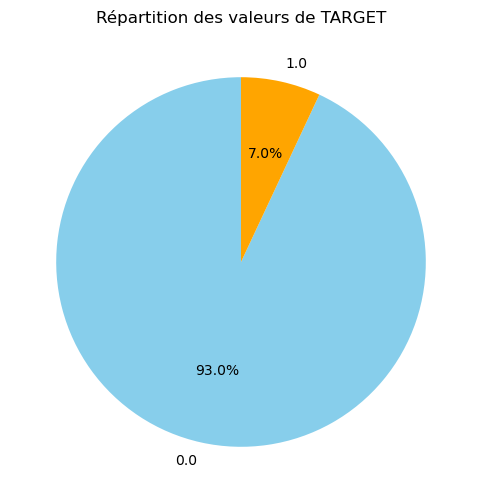

In [155]:
# Calcul des pourcentages de 0 et 1
pourcentage_target = df['TARGET'].value_counts(normalize=True) * 100

# Création du graphique en camembert
plt.figure(figsize=(6, 6))
plt.pie(pourcentage_target, labels=pourcentage_target.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'orange'])
plt.title("Répartition des valeurs de TARGET")
plt.show()

On observe une grande présence de la valeurs "0" dans cette variables. Il faudrait réfléchir à mettre en place à des procédés permettant la résolution de cette trop grande disparité.

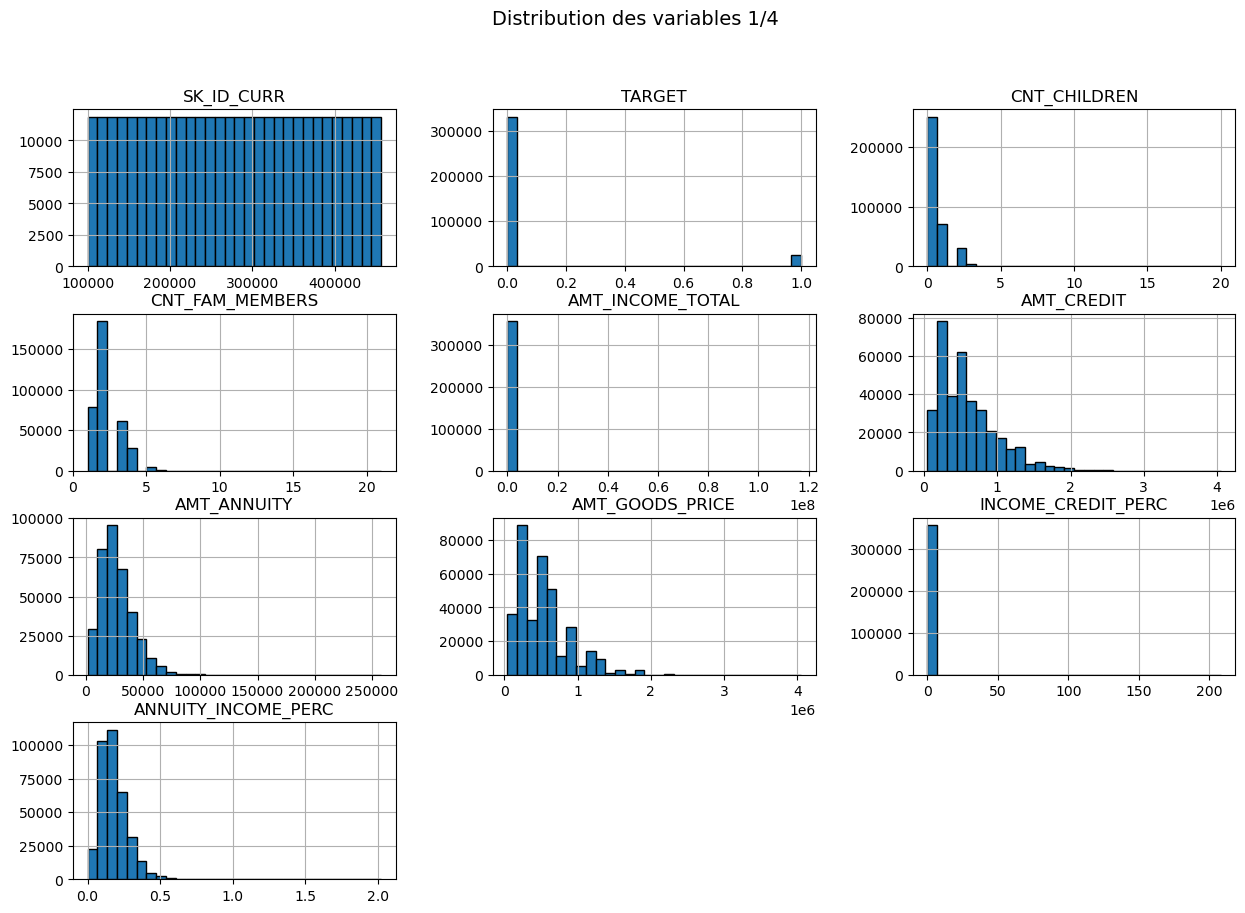

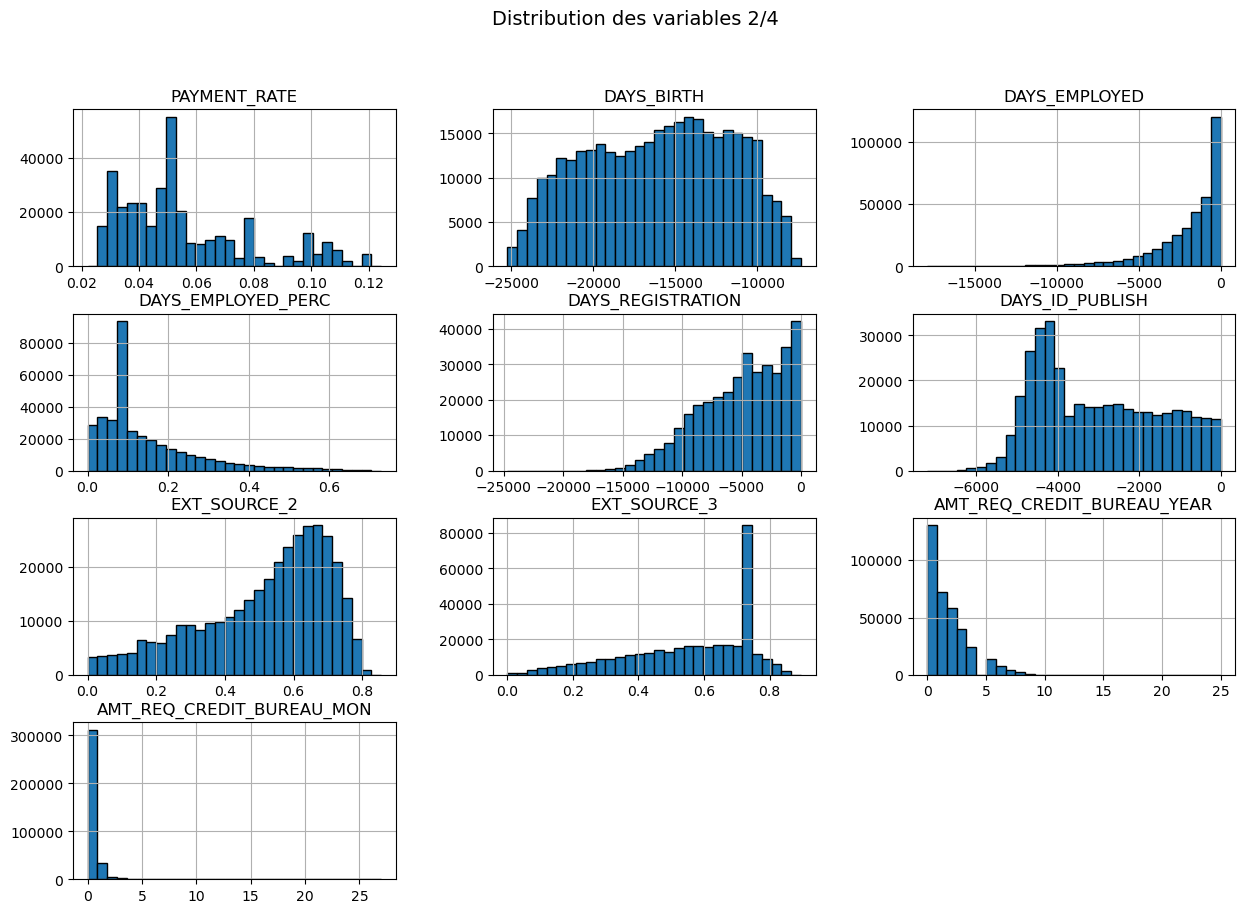

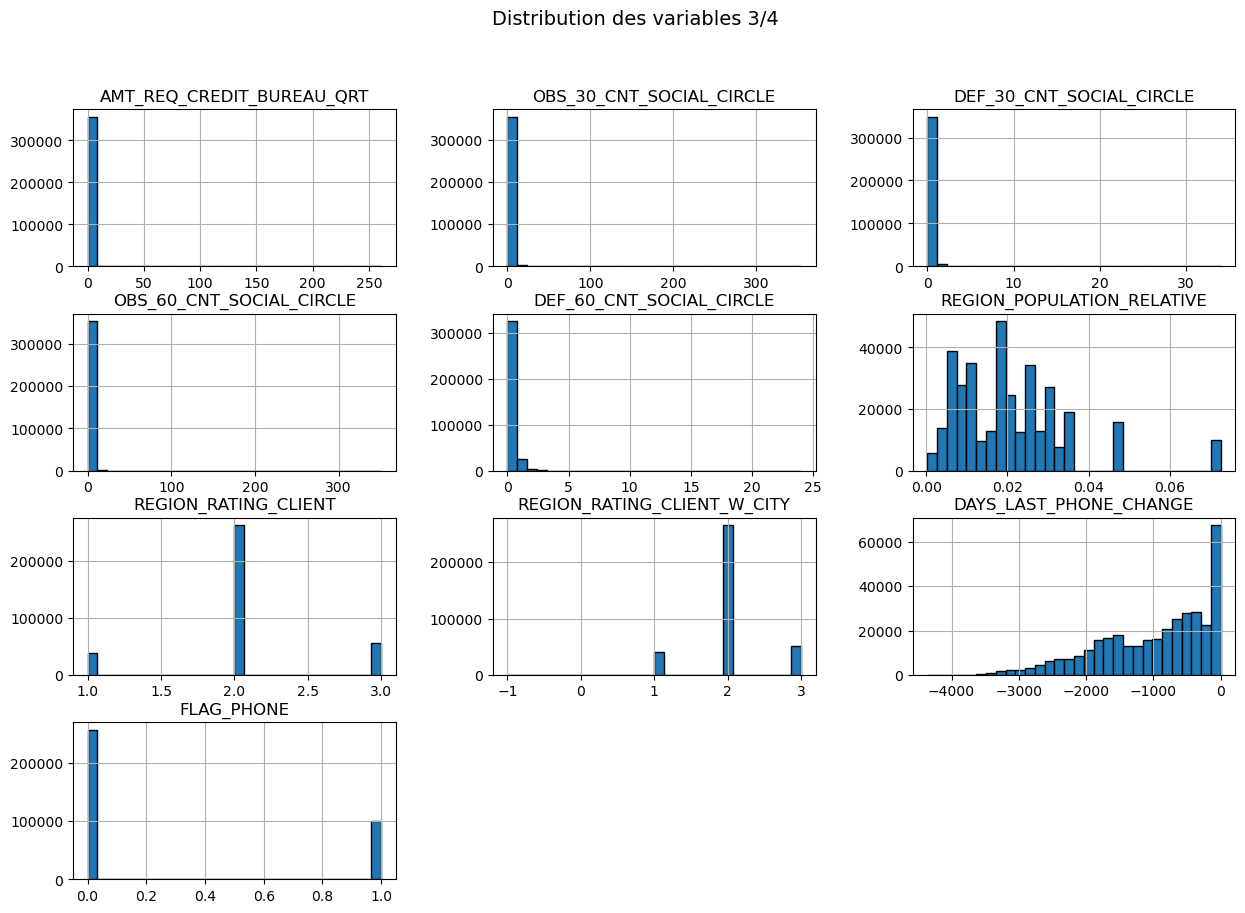

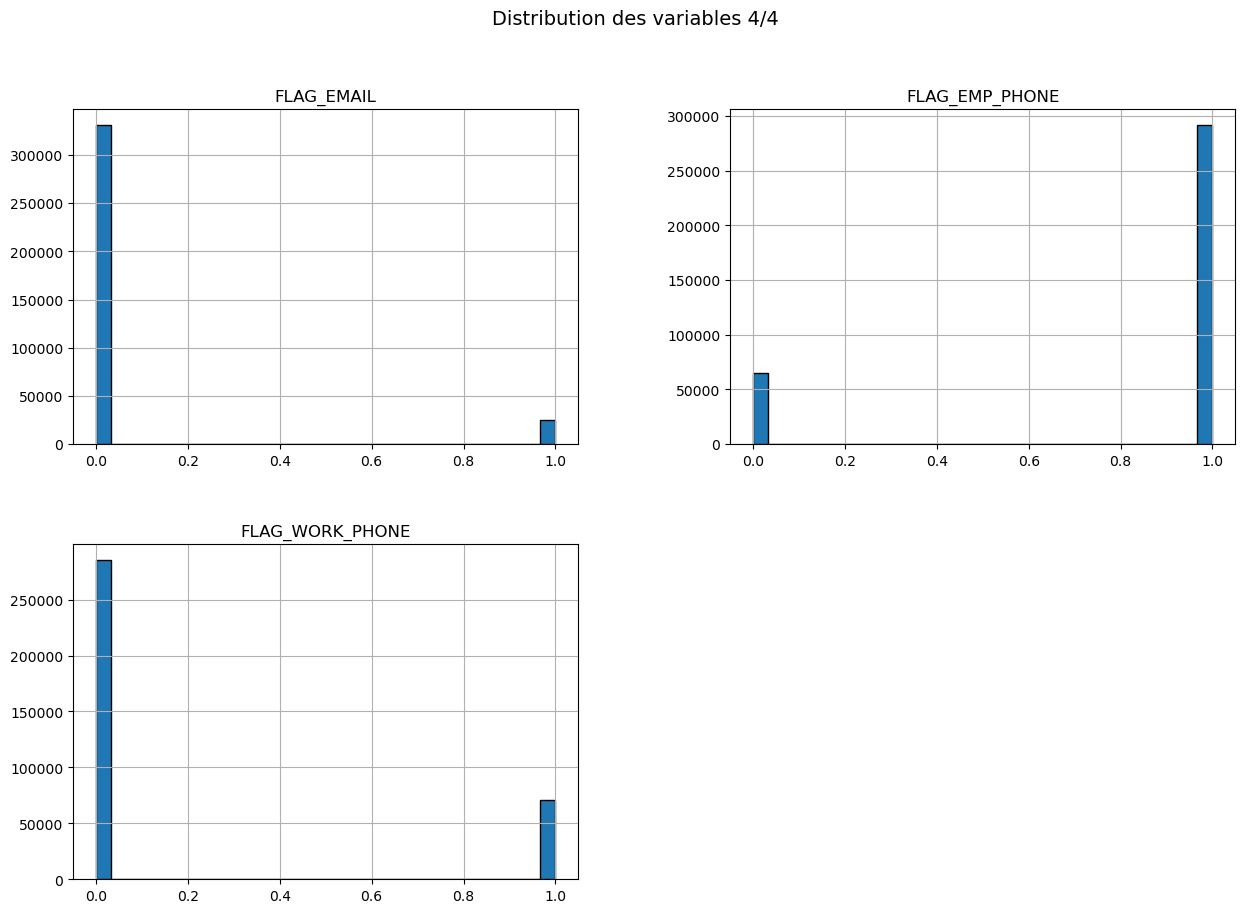

In [157]:
# Sélectionner uniquement les colonnes numériques
numerical_columns = df.select_dtypes(include=['number']).columns

# Définir le nombre de colonnes par figure
cols_per_figure = 10
num_cols = len(numerical_columns)
num_figures = np.ceil(num_cols / cols_per_figure).astype(int)

for i in range(num_figures):
    subset_cols = numerical_columns[i * cols_per_figure:(i + 1) * cols_per_figure]
    df[subset_cols].hist(figsize=(15, 10), bins=30, edgecolor='black')
    plt.suptitle(f"Distribution des variables {i+1}/{num_figures}", fontsize=14)
    plt.show()

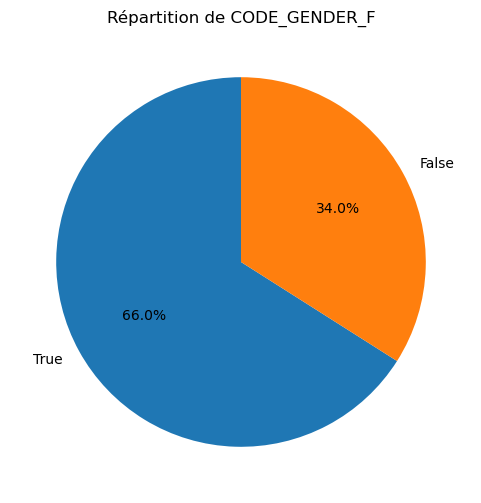

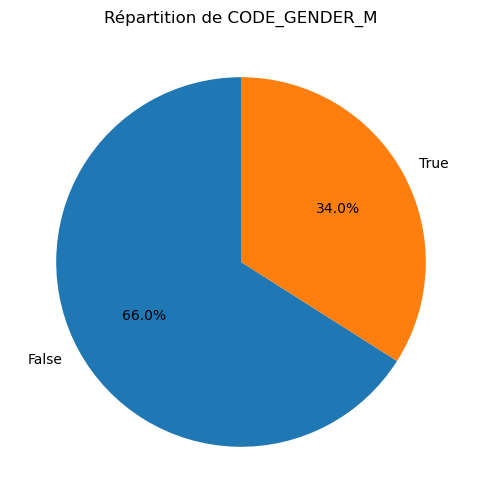

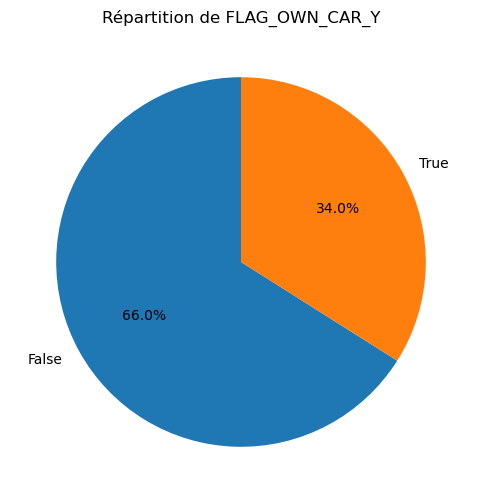

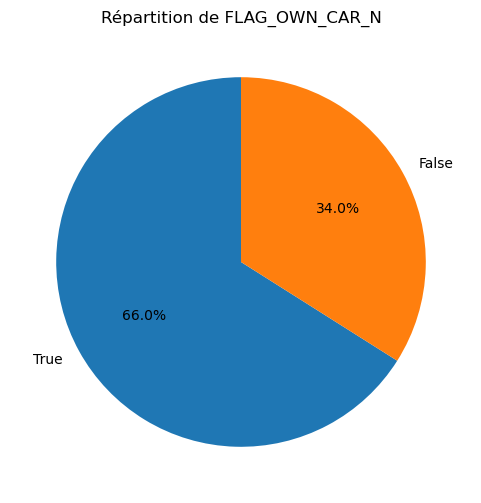

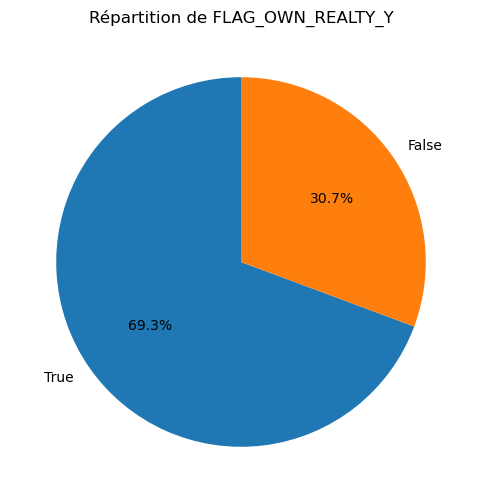

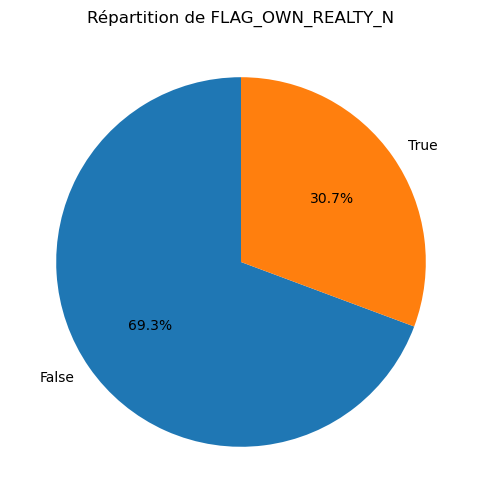

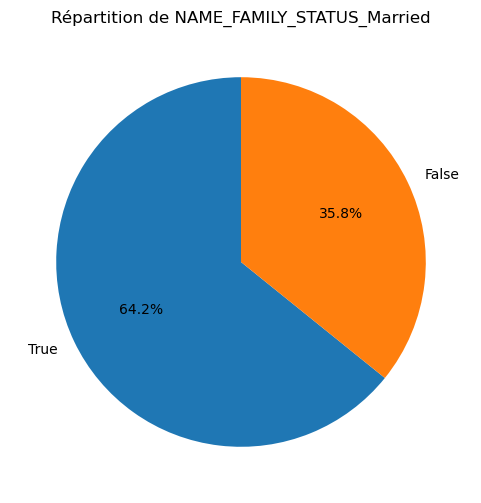

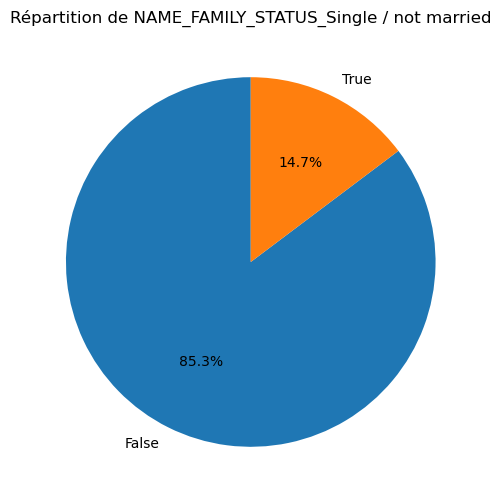

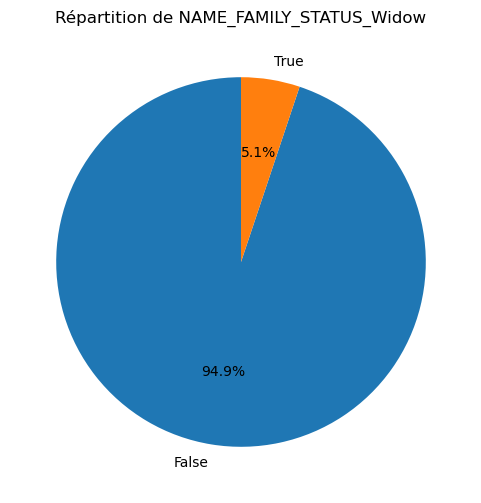

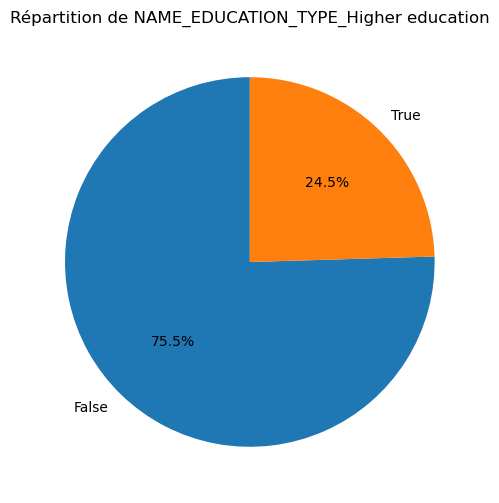

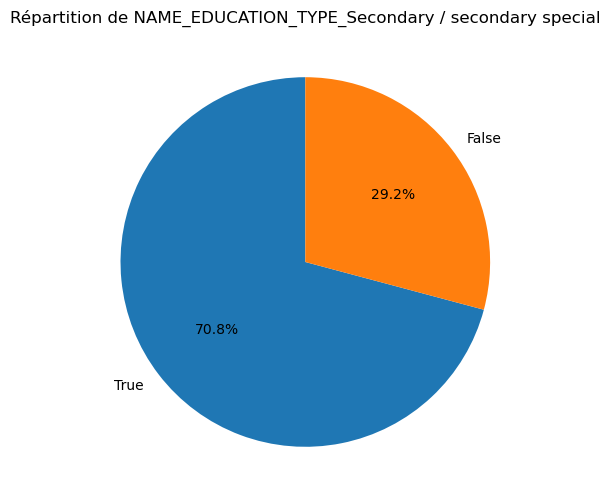

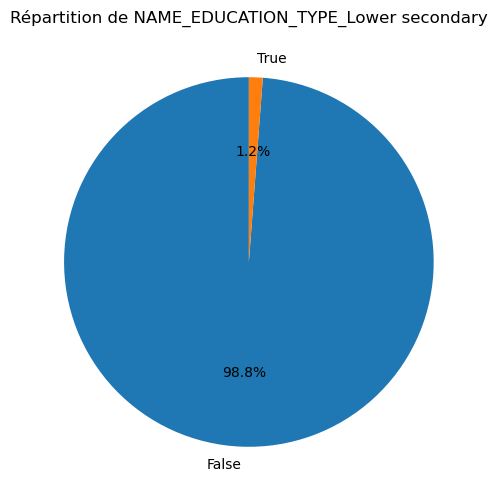

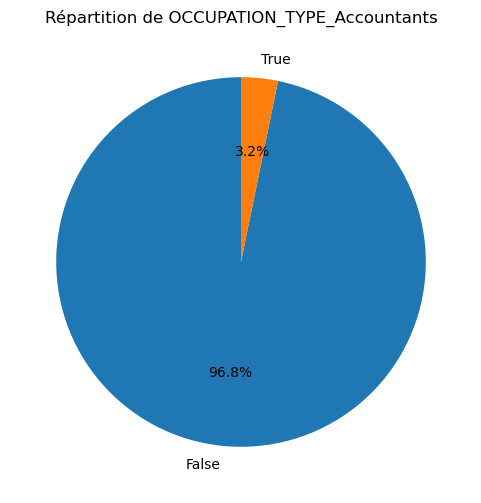

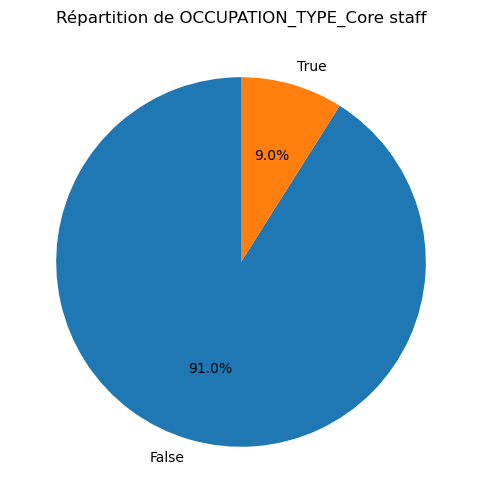

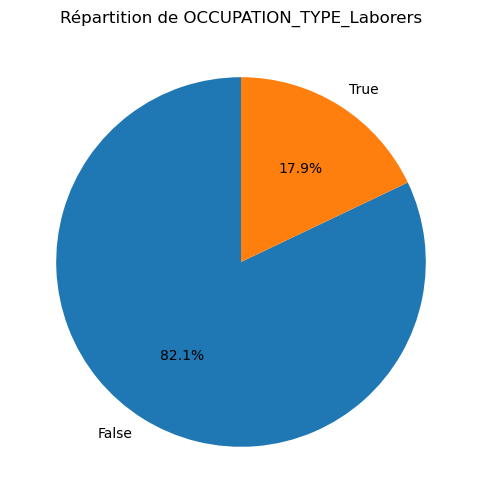

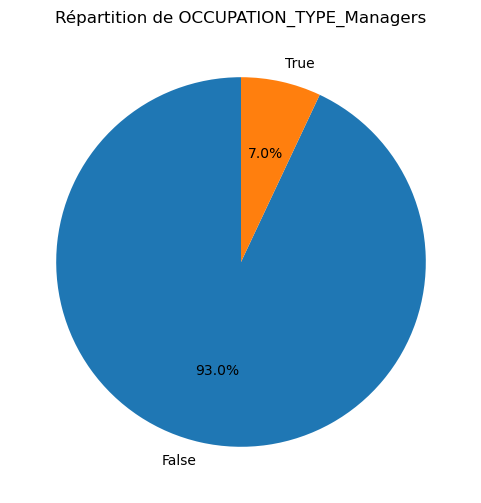

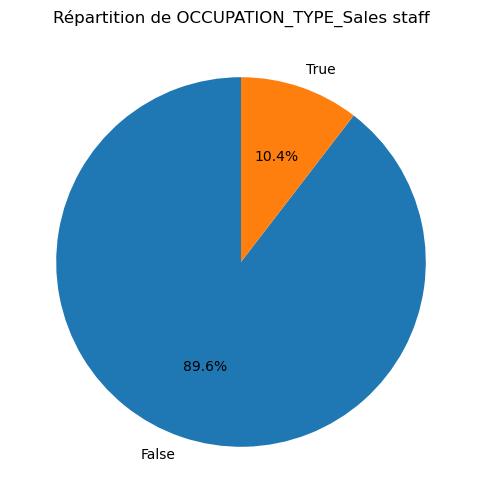

In [158]:
categorical_columns = df.select_dtypes(include=['object', 'category', 'bool']).columns

for col in categorical_columns:
    plt.figure(figsize=(6, 6))
    df[col].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%', startangle=90)
    plt.title(f"Répartition de {col}")
    plt.ylabel('')  # Cache le label inutile
    plt.show()

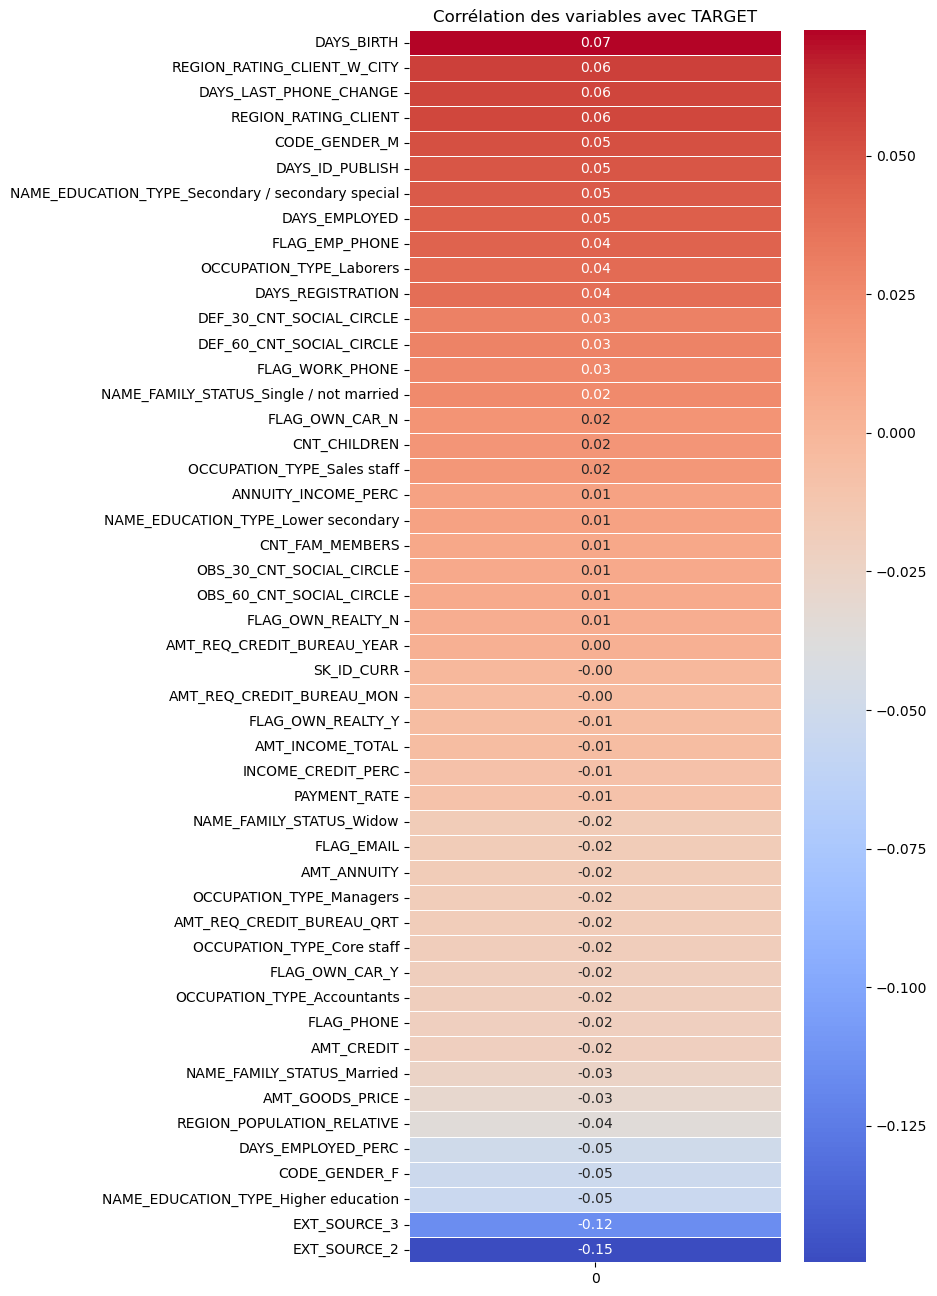

In [159]:
# Calcul des corrélations en excluant 'TARGET'
correlation_matrix = df.drop(columns=['TARGET']).corrwith(df['TARGET']).sort_values(ascending=False)

# Affichage sous forme de heatmap
plt.figure(figsize=(6, len(correlation_matrix) // 3))
sns.heatmap(correlation_matrix.to_frame(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Corrélation des variables avec TARGET")
plt.show()

Aucune variable ne semble corrélé avec notre cible. Il n'y a donc pas necessité d'en supprimé.

In [161]:
# Séparer les données en fonction de la colonne 'TARGET'
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]

# Séparation en features (X) et cible (y) pour le modèle
X = train_df.drop(columns=['TARGET', 'SK_ID_CURR'])
y = train_df['TARGET']

# Séparation en train et validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Tailles des datasets :\nX_train : {X_train.shape}\nX_val : {X_val.shape}\ny_train : {y_train.shape}\ny_val : {y_val.shape}")

Tailles des datasets :
X_train : (285000, 48)
X_val : (71251, 48)
y_train : (285000,)
y_val : (71251,)


In [162]:
# Afficher les premières colonnes pour s'assurer que tout est bon
print("Colonnes après récupération :", X_train.columns[:10])

Colonnes après récupération : Index(['CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'CODE_GENDER_F', 'CODE_GENDER_M',
       'FLAG_OWN_CAR_Y', 'FLAG_OWN_CAR_N', 'FLAG_OWN_REALTY_Y',
       'FLAG_OWN_REALTY_N', 'NAME_FAMILY_STATUS_Married',
       'NAME_FAMILY_STATUS_Single / not married'],
      dtype='object')


In [163]:
# Afficher les premières lignes des jeux de données
print("\nAperçu de y_train :")
print(y_train.head())

print("\nAperçu de y_val :")
print(y_val.head())


Aperçu de y_train :
202500    0.0
13114     0.0
154172    0.0
3033      0.0
239950    0.0
Name: TARGET, dtype: float64

Aperçu de y_val :
289346    0.0
226986    0.0
117159    0.0
170681    0.0
37056     0.0
Name: TARGET, dtype: float64


In [164]:
print("Distribution des classes dans y_train :")
print(y_train.value_counts(normalize=True))

print("\nDistribution des classes dans y_val :")
print(y_val.value_counts(normalize=True))

print("\nDistribution des classes globales :")
print(df['TARGET'].value_counts(normalize=True))


Distribution des classes dans y_train :
TARGET
0.0    0.930316
1.0    0.069684
Name: proportion, dtype: float64

Distribution des classes dans y_val :
TARGET
0.0    0.930317
1.0    0.069683
Name: proportion, dtype: float64

Distribution des classes globales :
TARGET
0.0    0.930316
1.0    0.069684
Name: proportion, dtype: float64


In [165]:
# Nettoyer les noms de colonnes en remplaçant les caractères spéciaux par des underscores
X_train.columns = X_train.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
X_val.columns = X_val.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)

# Vérifier les noms de colonnes après nettoyage
print(X_train.columns)

Index(['CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'CODE_GENDER_F', 'CODE_GENDER_M',
       'FLAG_OWN_CAR_Y', 'FLAG_OWN_CAR_N', 'FLAG_OWN_REALTY_Y',
       'FLAG_OWN_REALTY_N', 'NAME_FAMILY_STATUS_Married',
       'NAME_FAMILY_STATUS_Single_not_married', 'NAME_FAMILY_STATUS_Widow',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'INCOME_CREDIT_PERC', 'ANNUITY_INCOME_PERC', 'PAYMENT_RATE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_EMPLOYED_PERC',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'NAME_EDUCATION_TYPE_Higher_education',
       'NAME_EDUCATION_TYPE_Secondary_secondary_special',
       'NAME_EDUCATION_TYPE_Lower_secondary', 'OCCUPATION_TYPE_Accountants',
       'OCCUPATION_TYPE_Core_staff', 'OCCUPATION_TYPE_Laborers',
       'OCCUPATION_TYPE_Managers', 'OCCUPATION_TYPE_Sales_staff',
       'EXT_SOURCE_2', 'EXT_SOURCE_3', 'AMT_REQ_CREDIT_BUREAU_YEAR',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'OBS_30_CNT_SOCIAL_CIR


--- Fold 1 ---
[LightGBM] [Info] Number of positive: 15888, number of negative: 212112
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4047
[LightGBM] [Info] Number of data points in the train set: 228000, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Classification Report :
              precision    recall  f1-score   support

         0.0       0.97      0.71      0.82     53028
         1.0       0.15      0.66      0.24      3972

    accuracy                           0.71     57000
   macro avg       0.56      0.69      0.53     57000
weighted avg       0.91      0.71      0.78     57000

Matrice de confusion :
[[37655 15373]
 [ 1337  2635]]
AUC-ROC (Fold 1) : 

2025/03/18 20:10:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LightGBM_5Folds at: http://127.0.0.1:5000/#/experiments/607359786064919358/runs/a3dde8aa9d4644cc8523640bc96cbf63
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/607359786064919358


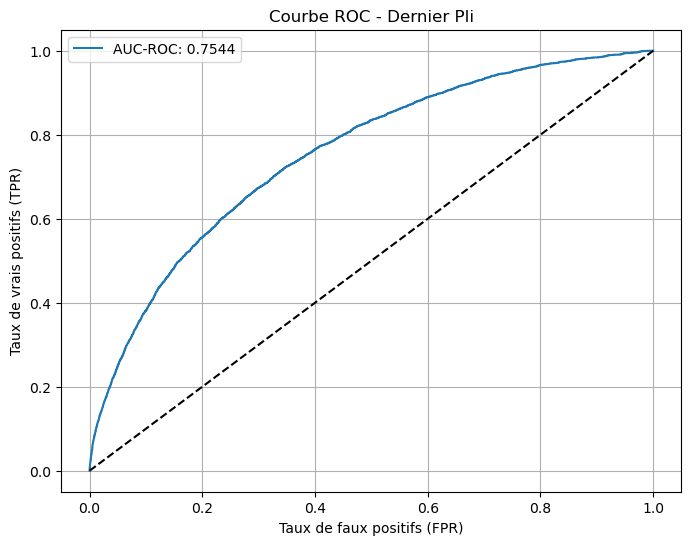

In [167]:
# Définir l'expérience MLflow
mlflow.set_experiment("LightGBM_CV_5Folds")

# Initialiser le modèle avec une pondération automatique des classes
model = LGBMClassifier(class_weight='balanced', random_state=42)

# Validation croisée stratifiée avec 5 plis
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Stockage des métriques par pli
roc_auc_scores = []

with mlflow.start_run(run_name="LightGBM_5Folds"):
    fold_idx = 1
    for train_idx, val_idx in cv.split(X_train, y_train):
        print(f"\n--- Fold {fold_idx} ---")
        
        # Séparation des données en plis d'entraînement et de validation
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        # Entraînement du modèle sur le pli d'entraînement
        model.fit(X_train_fold, y_train_fold)
        
        # Prédictions sur le pli de validation
        y_pred = model.predict(X_val_fold)
        y_pred_proba = model.predict_proba(X_val_fold)[:, 1]
        
        # Afficher les métriques de classification
        print("Classification Report :")
        print(classification_report(y_val_fold, y_pred))
        
        print("Matrice de confusion :")
        print(confusion_matrix(y_val_fold, y_pred))
        
        # Calculer l'AUC-ROC
        auc_score = roc_auc_score(y_val_fold, y_pred_proba)
        roc_auc_scores.append(auc_score)
        print(f"AUC-ROC (Fold {fold_idx}) : {auc_score:.4f}")
        
        # Enregistrement des métriques dans MLflow
        mlflow.log_metric(f"auc_roc_fold_{fold_idx}", auc_score)
        
        fold_idx += 1

    # Moyenne des métriques sur les 5 plis
    mean_auc = np.mean(roc_auc_scores)
    print(f"\nMétriques moyennes sur les 5 plis :")
    print(f"AUC-ROC Moyenne : {mean_auc:.4f}")
    
    # Enregistrement des métriques moyennes dans MLflow
    mlflow.log_metric("mean_auc_roc", mean_auc)
    
    # Enregistrement du modèle dans MLflow
    mlflow.sklearn.log_model(model, "LightGBM_Model")

# Tracer la courbe ROC globale (en utilisant les prédictions du dernier pli)
fpr, tpr, _ = roc_curve(y_val_fold, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC-ROC: {auc_score:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC - Dernier Pli')
plt.legend()
plt.grid()
plt.show()

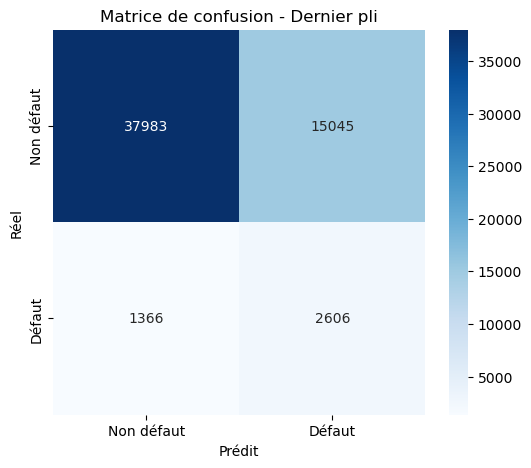

In [168]:
# Calcul de la matrice de confusion sur le dernier pli
cm = confusion_matrix(y_val_fold, y_pred)

# Affichage graphique de la matrice de confusion
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non défaut", "Défaut"], yticklabels=["Non défaut", "Défaut"])
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion - Dernier pli")
plt.show()

Les résultats obtenus semblent intérresants mais ils sont à prendre avec des pincettes. Certes le score AUC est relativement, il pourrait être meilleurs avec d'autres méthode que LightGBM. De plus la grande disparité entre les valeurs de TARGET devront etre rectifiés. Enfin un score métier devrait être mis en place afin d'optimiser le modèle pour le client.

## Cout métier

On se base à présent sur le score métier donner dans l'énoncer :

In [172]:
def score_metier(y_true, y_pred, fn_cost=10, fp_cost=1):
    """
    Calcul du score métier basé sur les coûts différenciés des FN et FP.
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Calcul du coût métier
    cost = (fn * fn_cost) + (fp * fp_cost)
    
    return cost

In [173]:
def find_best_threshold(model, X_val, y_val, fn_cost=10, fp_cost=1):
    """
    Recherche du seuil optimal pour minimiser le score métier.
    """
    # Prédictions en probabilités
    y_proba = model.predict_proba(X_val)[:, 1]
    
    # Calcul des différents seuils possibles via la courbe ROC
    fpr, tpr, thresholds = roc_curve(y_val, y_proba)
    
    # Calcul du score métier pour chaque seuil
    costs = []
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        cost = score_metier(y_val, y_pred, fn_cost, fp_cost)
        costs.append(cost)
    
    # Trouver le seuil avec le coût métier minimal
    optimal_idx = np.argmin(costs)
    optimal_threshold = thresholds[optimal_idx]
    
    print(f"Seuil optimal : {optimal_threshold:.4f} avec un coût métier de {costs[optimal_idx]}")
    
    return optimal_threshold, costs[optimal_idx]

In [174]:
# Enregistrement dans MLflow
with mlflow.start_run(run_name="Threshold_Optimization"):
    
    # Calcul du seuil optimal
    optimal_threshold, min_cost = find_best_threshold(model, X_val, y_val, fn_cost=10, fp_cost=1)
    
    # Prédictions avec le seuil optimisé
    y_proba = model.predict_proba(X_val)[:, 1]
    y_pred_optim = (y_proba >= optimal_threshold).astype(int)
    
    # Évaluation avec le score métier
    score = score_metier(y_val, y_pred_optim, fn_cost=10, fp_cost=1)
    print(f"Score métier (coût total) avec le seuil optimisé : {score}")
    
    # Comparaison avec des métriques classiques
    print("Classification Report :")
    print(classification_report(y_val, y_pred_optim))

    auc_roc = roc_auc_score(y_val, y_proba)
    print(f"AUC-ROC : {auc_roc:.4f}")
    
    # Enregistrement des métriques dans MLflow
    mlflow.log_metric("optimal_threshold", optimal_threshold)
    mlflow.log_metric("business_cost", score)
    mlflow.log_metric("auc_roc", auc_roc)
    
    # Enregistrement du modèle avec le seuil optimisé
    mlflow.sklearn.log_model(model, "Optimized_Model")

Seuil optimal : 0.5615 avec un coût métier de 35132
Score métier (coût total) avec le seuil optimisé : 35132
Classification Report :
              precision    recall  f1-score   support

         0.0       0.96      0.79      0.87     66286
         1.0       0.17      0.57      0.26      4965

    accuracy                           0.77     71251
   macro avg       0.57      0.68      0.56     71251
weighted avg       0.91      0.77      0.82     71251

AUC-ROC : 0.7577


2025/03/18 20:14:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Threshold_Optimization at: http://127.0.0.1:5000/#/experiments/607359786064919358/runs/7ca7986f3ead4169ac30f431cd4ce0f6
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/607359786064919358


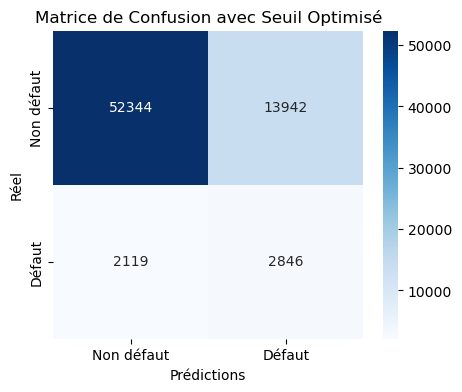

In [175]:
# Calcul de la matrice de confusion
cm = confusion_matrix(y_val, y_pred_optim)

# Affichage de la matrice de confusion avec Seaborn
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non défaut", "Défaut"], yticklabels=["Non défaut", "Défaut"])
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.title("Matrice de Confusion avec Seuil Optimisé")
plt.show()

Les résultats obtenus n'apportent pas suffisament àl'entreprise. Il faudrait trouver une méthodes pour combler d'éventuelles problèmes. Pour la suite nous utiliserons SMOTE pour régler le problème d'équilibrage de TARGET.

## Grid

Nous allons à présent tester différents modèles pour ne garder que le plus performants. Pour ce faire nous utiliserons GridSearch.

In [179]:
X_train.columns

Index(['CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'CODE_GENDER_F', 'CODE_GENDER_M',
       'FLAG_OWN_CAR_Y', 'FLAG_OWN_CAR_N', 'FLAG_OWN_REALTY_Y',
       'FLAG_OWN_REALTY_N', 'NAME_FAMILY_STATUS_Married',
       'NAME_FAMILY_STATUS_Single_not_married', 'NAME_FAMILY_STATUS_Widow',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'INCOME_CREDIT_PERC', 'ANNUITY_INCOME_PERC', 'PAYMENT_RATE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_EMPLOYED_PERC',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'NAME_EDUCATION_TYPE_Higher_education',
       'NAME_EDUCATION_TYPE_Secondary_secondary_special',
       'NAME_EDUCATION_TYPE_Lower_secondary', 'OCCUPATION_TYPE_Accountants',
       'OCCUPATION_TYPE_Core_staff', 'OCCUPATION_TYPE_Laborers',
       'OCCUPATION_TYPE_Managers', 'OCCUPATION_TYPE_Sales_staff',
       'EXT_SOURCE_2', 'EXT_SOURCE_3', 'AMT_REQ_CREDIT_BUREAU_YEAR',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'OBS_30_CNT_SOCIAL_CIR

In [180]:
# Nettoyage des colonnes en enlevant les caractères spéciaux et espaces
X_train.columns = X_train.columns.str.replace(r'[^A-Za-z0-9_]+', '_', regex=True).str.strip()
X_val.columns = X_val.columns.str.replace(r'[^A-Za-z0-9_]+', '_', regex=True).str.strip()

In [181]:
# Séparation des données en ensembles d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Modèles à tester
models = {
    'Dummy': DummyClassifier(strategy='most_frequent'),
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'LightGBM': LGBMClassifier(class_weight='balanced', random_state=42),
    'KNN': KNeighborsClassifier()
}

# Hyperparamètres à tester
param_grids = {
    'Dummy': {},
    'Logistic Regression': {'C': [0.1, 1]},
    'Random Forest': {'n_estimators': [50], 'max_depth': [4, 6]},
    'LightGBM': {'n_estimators': [50], 'max_depth': [4, 6]},
    'KNN': {'n_neighbors': [5]}
}

# Liste pour stocker les résultats
results = []

# Validation croisée stratifiée avec 3 plis
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

best_model = None
best_model_name = None
best_business_cost = float('inf')  # On veut minimiser ce score

for model_name, model in models.items():
    print(f"Entraînement du modèle : {model_name}")

    # Application de SMOTE pour équilibrer les classes
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Convertir en DataFrame pour conserver les noms de colonnes
    if isinstance(X_train_resampled, np.ndarray):
        X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)

    # Supprimer les caractères spéciaux des noms de colonnes
    X_train_resampled.columns = X_train_resampled.columns.str.replace(r'[^a-zA-Z0-9_]', '', regex=True)

    # Supprimer les runs actifs pour éviter les conflits
    mlflow.end_run()

    with mlflow.start_run(run_name=model_name):
        # Mesurer le temps d'exécution de la recherche de grille
        start_time = time.time()

        grid = GridSearchCV(model, param_grids[model_name], cv=cv, scoring='roc_auc', n_jobs=1, error_score='raise')
        grid.fit(X_train_resampled, y_train_resampled)

        end_time = time.time()
        grid_search_time = end_time - start_time

        best_model_current = grid.best_estimator_
        X_val.columns = X_val.columns.str.replace(r'[^a-zA-Z0-9_]', '', regex=True)
        y_pred_proba = best_model_current.predict_proba(X_val)[:, 1]

        # Calcul du meilleur seuil en fonction du coût métier
        seuils = np.linspace(0.1, 0.9, 100)
        best_score = float('inf')
        best_threshold = 0.5

        for seuil in seuils:
            y_pred = (y_pred_proba >= seuil).astype(int)
            tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
            cost = fn * 10 + fp  # Formule du coût métier
            if cost < best_score:
                best_score = cost
                best_threshold = seuil

        # Calcul de la performance
        roc_auc = roc_auc_score(y_val, y_pred_proba)

        # Ajout aux résultats
        results.append({
            'Model': model_name,
            'Best Params': grid.best_params_,
            'ROC AUC': roc_auc,
            'Best Threshold': best_threshold,
            'Business Cost': best_score,
            'Grid Search Time (s)': grid_search_time  # Ajout du temps de recherche
        })

        print(f"{model_name} - Meilleur seuil : {best_threshold:.4f}, Coût métier : {best_score}, Temps de recherche : {grid_search_time:.2f} secondes")

        # Enregistrement des métriques et du modèle dans MLflow
        mlflow.log_params(grid.best_params_)
        mlflow.log_metric("roc_auc", roc_auc)
        mlflow.log_metric("business_cost", best_score)
        mlflow.log_metric("best_threshold", best_threshold)
        mlflow.log_metric("grid_search_time", grid_search_time)
        mlflow.sklearn.log_model(best_model_current, f"model_{model_name}")

        # Vérification si c'est le meilleur modèle
        if best_score < best_business_cost:
            best_business_cost = best_score
            best_model = best_model_current
            best_model_name = model_name

# Affichage des résultats
results_df = pd.DataFrame(results)
print(results_df)
results_df.to_csv('model_comparison_results.csv', index=False)

# Vérifier si un meilleur modèle a été trouvé et l'enregistrer dans MLflow
if best_model:
    print(f"\nLe meilleur modèle est {best_model_name} avec un coût métier de {best_business_cost}")

    # Fermer un éventuel run actif
    mlflow.end_run()

    # Démarrer un run pour le modèle final
    with mlflow.start_run(run_name=f"Best_Model_{best_model_name}") as run:
        mlflow.sklearn.log_model(best_model, "best_model")

        # Récupérer le run_id pour l'enregistrement dans le Model Registry
        run_id = run.info.run_id
        model_uri = f"runs:/{run_id}/best_model"

        # Enregistrer le modèle dans le Model Registry MLflow
        mlflow.register_model(model_uri, "Best_Credit_Model")

    print(f"Meilleur modèle ({best_model_name}) enregistré avec succès sous 'Best_Credit_Model' avec le run_id : {run_id}")

else:
    print("Aucun modèle valide trouvé !")

Entraînement du modèle : Dummy
Dummy - Meilleur seuil : 0.1000, Coût métier : 49660, Temps de recherche : 0.91 secondes


2025/03/18 20:15:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Dummy at: http://127.0.0.1:5000/#/experiments/607359786064919358/runs/e0baf2694fe644c79f918c5aab784622
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/607359786064919358
Entraînement du modèle : Logistic Regression


C:\Users\guill\OneDrive\Documents\OpenClassroom\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\guill\OneDrive\Documents\OpenClassroom\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

Logistic Regression - Meilleur seuil : 0.5606, Coût métier : 47365, Temps de recherche : 272.01 secondes


2025/03/18 20:19:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Logistic Regression at: http://127.0.0.1:5000/#/experiments/607359786064919358/runs/63c214a38bfc45a9a3c3f4f62b2f0b44
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/607359786064919358
Entraînement du modèle : Random Forest
Random Forest - Meilleur seuil : 0.4152, Coût métier : 45333, Temps de recherche : 197.12 secondes


2025/03/18 20:23:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Random Forest at: http://127.0.0.1:5000/#/experiments/607359786064919358/runs/3ada46770a9345899fed6f89eacf6efe
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/607359786064919358
Entraînement du modèle : LightGBM
[LightGBM] [Info] Number of positive: 176761, number of negative: 176760
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045777 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6181
[LightGBM] [Info] Number of data points in the train set: 353521, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

2025/03/18 20:23:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LightGBM at: http://127.0.0.1:5000/#/experiments/607359786064919358/runs/ffaa4d5ec7634d248e70d01ddbfb41b9
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/607359786064919358
Entraînement du modèle : KNN
KNN - Meilleur seuil : 0.8030, Coût métier : 48662, Temps de recherche : 228.39 secondes


2025/03/18 20:28:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run KNN at: http://127.0.0.1:5000/#/experiments/607359786064919358/runs/de4aa249fc244980a385ab3a5ca2c8df
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/607359786064919358
                 Model                           Best Params   ROC AUC  \
0                Dummy                                    {}  0.500000   
1  Logistic Regression                              {'C': 1}  0.613567   
2        Random Forest  {'max_depth': 6, 'n_estimators': 50}  0.635249   
3             LightGBM  {'max_depth': 6, 'n_estimators': 50}  0.703622   
4                  KNN                    {'n_neighbors': 5}  0.560034   

   Best Threshold  Business Cost  Grid Search Time (s)  
0        0.100000          49660              0.913020  
1        0.560606          47365            272.013575  
2        0.415152          45333            197.124300  
3        0.156566          39623             15.567326  
4        0.803030          48662            228.389442  

Le meilleur modèle est 

2025/03/18 20:28:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'Best_Credit_Model' already exists. Creating a new version of this model...
2025/03/18 20:28:32 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Best_Credit_Model, version 7


🏃 View run Best_Model_LightGBM at: http://127.0.0.1:5000/#/experiments/607359786064919358/runs/398303ff08d549fb8f2276153601e406
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/607359786064919358
Meilleur modèle (LightGBM) enregistré avec succès sous 'Best_Credit_Model' avec le run_id : 398303ff08d549fb8f2276153601e406


Created version '7' of model 'Best_Credit_Model'.


Les résultats obtenus nous confortents dans l'idée de lightgbm. De plus l'utilisation de smote permet cette fois d'équilibrer TARGET et donc de permettre à notre modèle d'apprendre de manière plus efficace.

## Feature Importance

### Importance globale

In [186]:
# Nettoyage des colonnes en enlevant les caractères spéciaux et espaces
X_train.columns = X_train.columns.str.replace(r'[^A-Za-z0-9_]+', '_', regex=True).str.strip()
X_val.columns = X_val.columns.str.replace(r'[^A-Za-z0-9_]+', '_', regex=True).str.strip()

[LightGBM] [Info] Number of positive: 265141, number of negative: 265141
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6182
[LightGBM] [Info] Number of data points in the train set: 530282, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Seuil optimal : 0.1566 avec un coût métier de 39623
Coût métier après optimisation du seuil : 39623


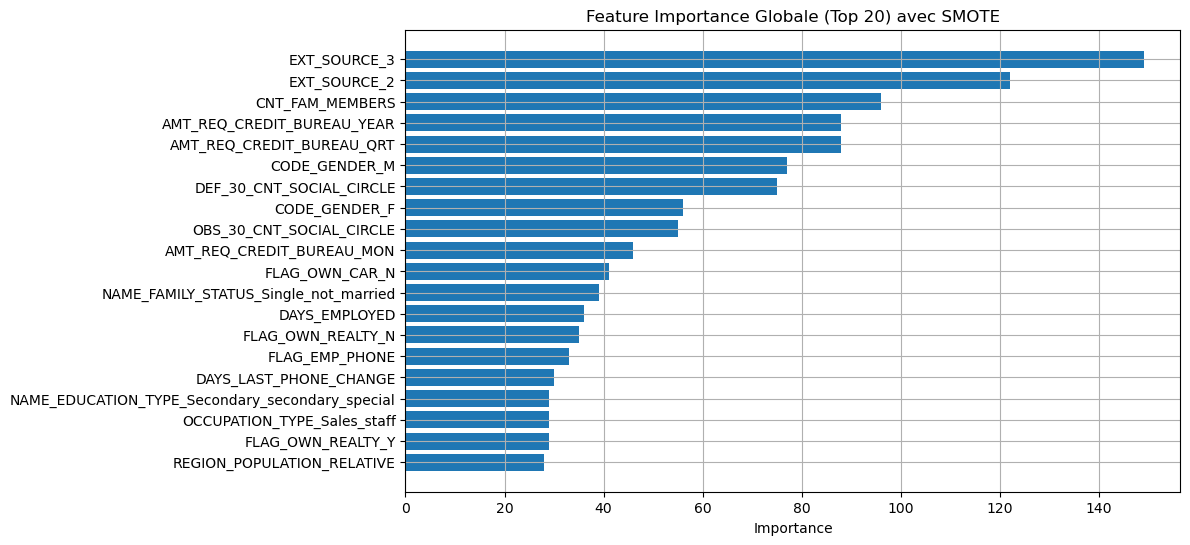

Feature Importances :
[ 13  96  56  77  28  41  29  35  20  39  12   1  10   0   3  17   2  24
  10  36  13   4  18  21  29  17   1  18  25   9  29 122 149  88  46  88
  55  75  15   6  28   9   3  30   9   8  33   3]
Somme des importances : 1500


In [187]:
# Application de SMOTE pour équilibrer les classes
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Nettoyage des noms de colonnes après SMOTE
X_train_resampled.columns = X_train_resampled.columns.str.replace(r'[^A-Za-z0-9_]+', '_', regex=True).str.strip()

# Entraînement du modèle LightGBM
model = lgb.LGBMClassifier(class_weight='balanced', max_depth=6, n_estimators=50, random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# Calcul du seuil optimal basé sur le coût métier
def score_metier(y_true, y_pred, fn_cost=10, fp_cost=1):
    """Calcul du score métier basé sur les coûts des faux négatifs et faux positifs."""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return (fn * fn_cost) + (fp * fp_cost)

# Prédictions en probabilités
y_proba = model.predict_proba(X_val)[:, 1]

# Tester plusieurs seuils pour minimiser le coût métier
seuils = np.linspace(0.1, 0.9, 100)
best_score = float('inf')
best_threshold = 0.5

for seuil in seuils:
    y_pred = (y_proba >= seuil).astype(int)
    cost = score_metier(y_val, y_pred, fn_cost=10, fp_cost=1)
    if cost < best_score:
        best_score = cost
        best_threshold = seuil

print(f"Seuil optimal : {best_threshold:.4f} avec un coût métier de {best_score}")

# Appliquer le seuil optimal et recalculer les métriques
y_pred_optim = (y_proba >= best_threshold).astype(int)
final_cost = score_metier(y_val, y_pred_optim, fn_cost=10, fp_cost=1)
print(f"Coût métier après optimisation du seuil : {final_cost}")

# Récupérer et afficher les importances des features
feature_importances = model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Affichage des 20 features les plus importantes
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].head(20), importance_df['Importance'].head(20))
plt.xlabel('Importance')
plt.title('Feature Importance Globale (Top 20) avec SMOTE')
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()

# Vérification des valeurs d'importances
print("Feature Importances :")
print(feature_importances)
print(f"Somme des importances : {sum(feature_importances)}")

### Importance locale

[LightGBM] [Info] Number of positive: 265141, number of negative: 265141
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6182
[LightGBM] [Info] Number of data points in the train set: 530282, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Seuil optimal : 0.1566 avec un coût métier de 39623
Coût métier après optimisation du seuil : 39623


C:\Users\guill\OneDrive\Documents\OpenClassroom\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


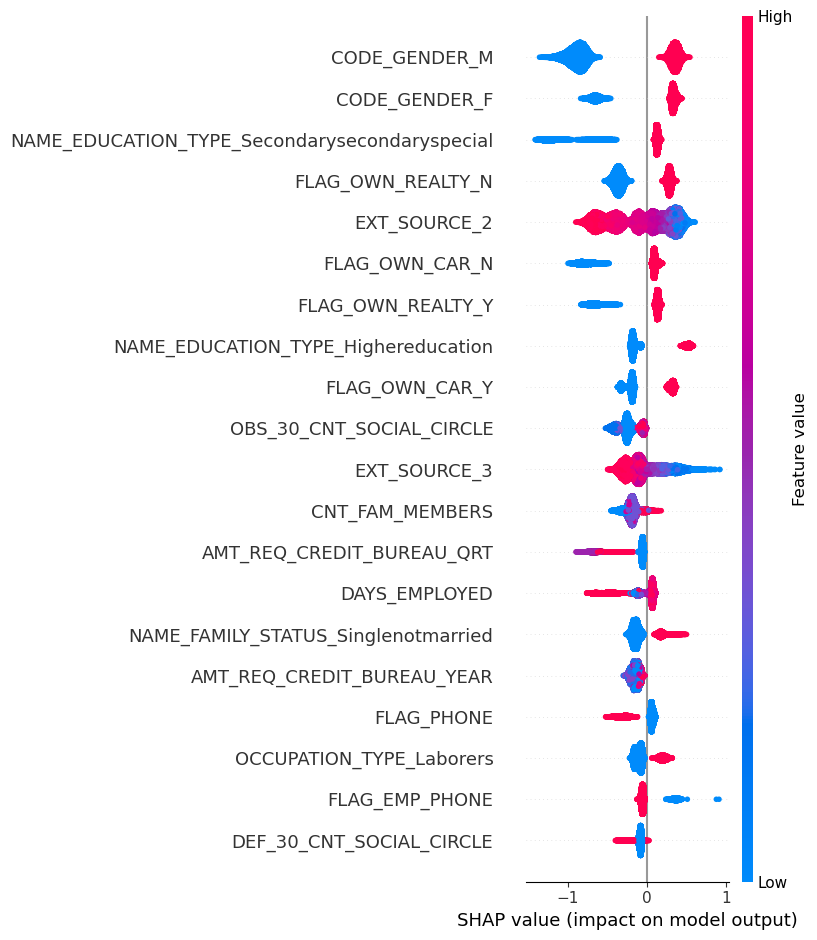

In [189]:
# Nettoyage des noms de colonnes pour éviter l'erreur LightGBM
X_train.columns = X_train.columns.str.replace(r'[^A-Za-z0-9_]+', '_', regex=True).str.strip()
X_val.columns = X_val.columns.str.replace(r'[^A-Za-z0-9_]+', '_', regex=True).str.strip()

# Application de SMOTE sur l'ensemble d'entraînement
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Nettoyage des noms de colonnes après SMOTE
X_train_resampled.columns = X_train_resampled.columns.str.replace(r'[^A-Za-z0-9_]+', '_', regex=True).str.strip()

# Entraînement du modèle LightGBM 
model = lgb.LGBMClassifier(class_weight='balanced', max_depth=6, n_estimators=50, random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# Calcul du seuil optimal basé sur le coût métier
def score_metier(y_true, y_pred, fn_cost=10, fp_cost=1):
    """Calcul du score métier basé sur les coûts des faux négatifs et faux positifs."""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return (fn * fn_cost) + (fp * fp_cost)

# Prédictions en probabilités
y_proba = model.predict_proba(X_val)[:, 1]

# Tester plusieurs seuils pour minimiser le coût métier
seuils = np.linspace(0.1, 0.9, 100)
best_score = float('inf')
best_threshold = 0.5

for seuil in seuils:
    y_pred = (y_proba >= seuil).astype(int)
    cost = score_metier(y_val, y_pred, fn_cost=10, fp_cost=1)
    if cost < best_score:
        best_score = cost
        best_threshold = seuil

print(f"Seuil optimal : {best_threshold:.4f} avec un coût métier de {best_score}")

# Appliquer le seuil optimal et recalculer les métriques
y_pred_optim = (y_proba >= best_threshold).astype(int)
final_cost = score_metier(y_val, y_pred_optim, fn_cost=10, fp_cost=1)
print(f"Coût métier après optimisation du seuil : {final_cost}")

# Importance locale avec SHAP ===
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val)

# Visualisation de l'importance locale avec un summary plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_val)

## Données necessaire à API

In [191]:
# 🔹 Renommer les colonnes pour qu'elles soient compatibles avec JSON
df.columns = df.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)

In [192]:
# Afficher toutes les colonnes
print(df.columns.tolist())

['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'CODE_GENDER_F', 'CODE_GENDER_M', 'FLAG_OWN_CAR_Y', 'FLAG_OWN_CAR_N', 'FLAG_OWN_REALTY_Y', 'FLAG_OWN_REALTY_N', 'NAME_FAMILY_STATUS_Married', 'NAME_FAMILY_STATUS_Single_not_married', 'NAME_FAMILY_STATUS_Widow', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'INCOME_CREDIT_PERC', 'ANNUITY_INCOME_PERC', 'PAYMENT_RATE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_EMPLOYED_PERC', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'NAME_EDUCATION_TYPE_Higher_education', 'NAME_EDUCATION_TYPE_Secondary_secondary_special', 'NAME_EDUCATION_TYPE_Lower_secondary', 'OCCUPATION_TYPE_Accountants', 'OCCUPATION_TYPE_Core_staff', 'OCCUPATION_TYPE_Laborers', 'OCCUPATION_TYPE_Managers', 'OCCUPATION_TYPE_Sales_staff', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE

In [193]:
# Définition des variables
target = "TARGET"  # Colonne cible
id_column = "SK_ID_CURR"  # Identifiant client à exclure

# Exclure l'identifiant et garder toutes les autres variables
X = df.drop(columns=[target, id_column], errors='ignore')
y = df[target]

# Supprimer les valeurs manquantes
df_clean = df.dropna()

# Séparation Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Appliquer SMOTE pour équilibrer les classes
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Entraînement du modèle LightGBM
model = lgb.LGBMClassifier(class_weight='balanced', max_depth=6, n_estimators=50, random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# Évaluation
y_pred_proba = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC du modèle : {roc_auc:.4f}")

# Trouver le seuil optimal basé sur le coût métier
seuils = np.linspace(0.1, 0.9, 100)
best_score = float('inf')
best_threshold = 0.5

for seuil in seuils:
    y_pred = (y_pred_proba >= seuil).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    cost = fn * 10 + fp  # Coût métier : FN coûte 10x plus cher que FP
    if cost < best_score:
        best_score = cost
        best_threshold = seuil

print(f"Seuil optimal : {best_threshold:.4f}, Coût métier minimal : {best_score}")

[LightGBM] [Info] Number of positive: 265140, number of negative: 265140
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6181
[LightGBM] [Info] Number of data points in the train set: 530280, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
ROC AUC du modèle : 0.7083
Seuil optimal : 0.1485, Coût métier minimal : 39477


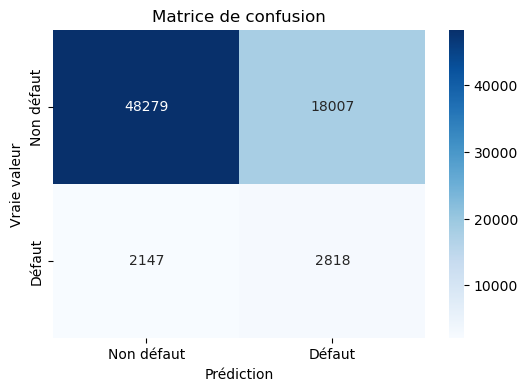

In [199]:
# Générer les prédictions finales avec le seuil optimal
y_pred_final = (y_pred_proba >= best_threshold).astype(int)

# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_final)

# Affichage de la matrice de confusion
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non défaut", "Défaut"], yticklabels=["Non défaut", "Défaut"])
plt.xlabel("Prédiction")
plt.ylabel("Vraie valeur")
plt.title("Matrice de confusion")
plt.show()

In [45]:
# Sauvegarde du modèle et du seuil optimal
joblib.dump((model, best_threshold), "best_lightgbm_model.pkl")
print("Modèle et seuil sauvegardés sous 'best_lightgbm_model.pkl'")

Modèle et seuil sauvegardés sous 'best_lightgbm_model.pkl'
